In [80]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import warnings
import numpy as np
warnings.filterwarnings('ignore')

df2 = pd.read_csv('../../data/daily_sunspots_time_series_1850-01_2024-05.csv')

In [81]:
data3 = df2[["date","counts"]]
data3['date'] = pd.to_datetime(data3['date'])

In [82]:
# train.shape

In [83]:
train = data3.iloc[:-30]
test = data3.iloc[-30:]

train.shape
test.shape


(30, 2)

In [84]:
train.head()

,date,counts
0,1850-01-01,253
1,1850-01-02,162
2,1850-01-03,217
3,1850-01-04,99
4,1850-01-05,108


In [85]:
train['timestep'] = list(range(train.shape[0]))

In [86]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63643 entries, 0 to 63642
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      63643 non-null  datetime64[ns]
 1   counts    63643 non-null  int64         
 2   timestep  63643 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.5 MB


Model

In [87]:
train.head()

,date,counts,timestep
0,1850-01-01,253,0
1,1850-01-02,162,1
2,1850-01-03,217,2
3,1850-01-04,99,3
4,1850-01-05,108,4


In [88]:
train.set_index(train['date'], inplace = True)

In [89]:
train.drop('date', axis=1)

,counts,timestep
date,,
1850-01-01,253,0
1850-01-02,162,1
1850-01-03,217,2
1850-01-04,99,3
1850-01-05,108,4
...,...,...
2024-03-27,114,63638
2024-03-28,98,63639
2024-03-29,81,63640


Baseline Model

In [90]:
X_trend = train[['timestep']]
y_trend = train['counts']

In [91]:
X_trend

,timestep
date,
1850-01-01,0
1850-01-02,1
1850-01-03,2
1850-01-04,3
1850-01-05,4
...,...
2024-03-27,63638
2024-03-28,63639
2024-03-29,63640


In [92]:
from sklearn.preprocessing import (
    PolynomialFeatures,
    OneHotEncoder
)
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

import matplotlib as mpl
import seaborn as sns

trend_model = make_pipeline(
    PolynomialFeatures(degree=3),
    LinearRegression()
)

trend_model.fit(X_trend,y_trend)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('linearregression', LinearRegression())])

In [93]:

train['trend'] = trend_model.predict(X_trend)
train['trend']

date
1850-01-01    114.032692
1850-01-02    114.025075
1850-01-03    114.017459
1850-01-04    114.009844
1850-01-05    114.002229
                 ...    
2024-03-27     28.760816
2024-03-28     28.750937
2024-03-29     28.741058
2024-03-30     28.731178
2024-03-31     28.721297
Name: trend, Length: 63643, dtype: float64

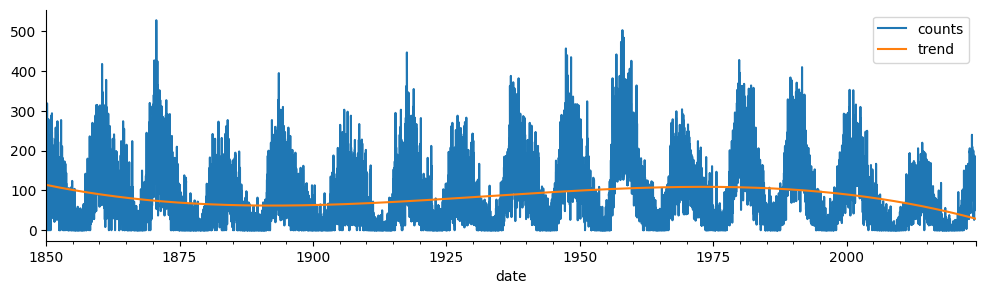

In [94]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train[['counts','trend']].plot(legend=True)
sns.despine()

**detrended data**

In [95]:
train['detrended'] = train['counts'] - train['trend']
train

,date,counts,timestep,trend,detrended
date,,,,,
1850-01-01,1850-01-01,253,0,114.032692,138.967308
1850-01-02,1850-01-02,162,1,114.025075,47.974925
1850-01-03,1850-01-03,217,2,114.017459,102.982541
1850-01-04,1850-01-04,99,3,114.009844,-15.009844
1850-01-05,1850-01-05,108,4,114.002229,-6.002229
...,...,...,...,...,...
2024-03-27,2024-03-27,114,63638,28.760816,85.239184
2024-03-28,2024-03-28,98,63639,28.750937,69.249063
2024-03-29,2024-03-29,81,63640,28.741058,52.258942


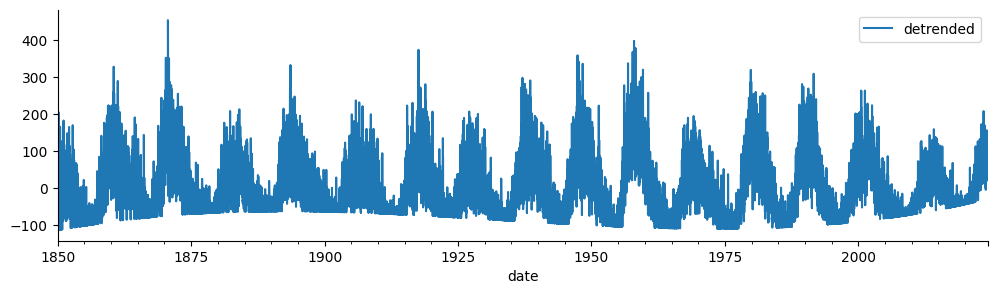

In [96]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train['detrended'].plot(legend=True)
sns.despine()

In [97]:
train['month'] = train.index.month
train

,date,counts,timestep,trend,detrended,month
date,,,,,,
1850-01-01,1850-01-01,253,0,114.032692,138.967308,1
1850-01-02,1850-01-02,162,1,114.025075,47.974925,1
1850-01-03,1850-01-03,217,2,114.017459,102.982541,1
1850-01-04,1850-01-04,99,3,114.009844,-15.009844,1
1850-01-05,1850-01-05,108,4,114.002229,-6.002229,1
...,...,...,...,...,...,...
2024-03-27,2024-03-27,114,63638,28.760816,85.239184,3
2024-03-28,2024-03-28,98,63639,28.750937,69.249063,3
2024-03-29,2024-03-29,81,63640,28.741058,52.258942,3


In [98]:
X_seasonality = train[['month']]
y_seasonality = train['detrended']

seasonality_model = make_pipeline(
    OneHotEncoder(drop='first'),
    LinearRegression()
)

seasonality_model.fit(X_seasonality, y_seasonality)

Pipeline(steps=[('onehotencoder', OneHotEncoder(drop='first')),
                ('linearregression', LinearRegression())])

In [99]:
train['seasonality'] = seasonality_model.predict(X_seasonality)
train

,date,counts,timestep,trend,detrended,month,seasonality
date,,,,,,,
1850-01-01,1850-01-01,253,0,114.032692,138.967308,1,-3.871431
1850-01-02,1850-01-02,162,1,114.025075,47.974925,1,-3.871431
1850-01-03,1850-01-03,217,2,114.017459,102.982541,1,-3.871431
1850-01-04,1850-01-04,99,3,114.009844,-15.009844,1,-3.871431
1850-01-05,1850-01-05,108,4,114.002229,-6.002229,1,-3.871431
...,...,...,...,...,...,...,...
2024-03-27,2024-03-27,114,63638,28.760816,85.239184,3,-0.513842
2024-03-28,2024-03-28,98,63639,28.750937,69.249063,3,-0.513842
2024-03-29,2024-03-29,81,63640,28.741058,52.258942,3,-0.513842


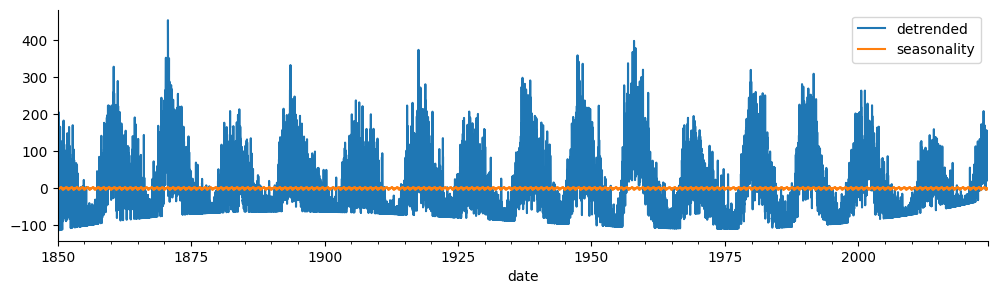

In [100]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train[['detrended','seasonality']].plot(legend=True)
sns.despine()

In [101]:
# from qcd import qcd_variance as qcd_variance
# import numpy as np



In [102]:
# qcd = qcd_variance(train['counts'])

In [103]:
def qcd_variance(series,window=4000):
    """
    This function returns the quartile coefficient of dispersion
    of the rolling variance of a series in a given window range 
    """
    # rolling variance for a given window 
    variances = series.rolling(window).var().dropna()
    # first quartile
    Q1 = np.percentile(variances, 25, interpolation='midpoint')
    # third quartile
    Q3 = np.percentile(variances, 75, interpolation='midpoint')
    # quartile coefficient of dispersion 
    qcd = round((Q3-Q1)/(Q3+Q1),6)
    
    print(f"quartile coefficient of dispersion: {qcd}")

In [104]:
qcd_variance(train['counts'])

quartile coefficient of dispersion: 0.348447


In [105]:
qcd_variance(train['detrended'])

quartile coefficient of dispersion: 0.340575


In [106]:
train


,date,counts,timestep,trend,detrended,month,seasonality
date,,,,,,,
1850-01-01,1850-01-01,253,0,114.032692,138.967308,1,-3.871431
1850-01-02,1850-01-02,162,1,114.025075,47.974925,1,-3.871431
1850-01-03,1850-01-03,217,2,114.017459,102.982541,1,-3.871431
1850-01-04,1850-01-04,99,3,114.009844,-15.009844,1,-3.871431
1850-01-05,1850-01-05,108,4,114.002229,-6.002229,1,-3.871431
...,...,...,...,...,...,...,...
2024-03-27,2024-03-27,114,63638,28.760816,85.239184,3,-0.513842
2024-03-28,2024-03-28,98,63639,28.750937,69.249063,3,-0.513842
2024-03-29,2024-03-29,81,63640,28.741058,52.258942,3,-0.513842


In [107]:
train['trend_seasonal'] = train['trend'] + train['seasonality']

train['remainder'] = train['counts']-train['trend_seasonal']
train

,date,counts,timestep,trend,detrended,month,seasonality,trend_seasonal,remainder
date,,,,,,,,,
1850-01-01,1850-01-01,253,0,114.032692,138.967308,1,-3.871431,110.161261,142.838739
1850-01-02,1850-01-02,162,1,114.025075,47.974925,1,-3.871431,110.153644,51.846356
1850-01-03,1850-01-03,217,2,114.017459,102.982541,1,-3.871431,110.146028,106.853972
1850-01-04,1850-01-04,99,3,114.009844,-15.009844,1,-3.871431,110.138413,-11.138413
1850-01-05,1850-01-05,108,4,114.002229,-6.002229,1,-3.871431,110.130798,-2.130798
...,...,...,...,...,...,...,...,...,...
2024-03-27,2024-03-27,114,63638,28.760816,85.239184,3,-0.513842,28.246974,85.753026
2024-03-28,2024-03-28,98,63639,28.750937,69.249063,3,-0.513842,28.237095,69.762905
2024-03-29,2024-03-29,81,63640,28.741058,52.258942,3,-0.513842,28.227216,52.772784


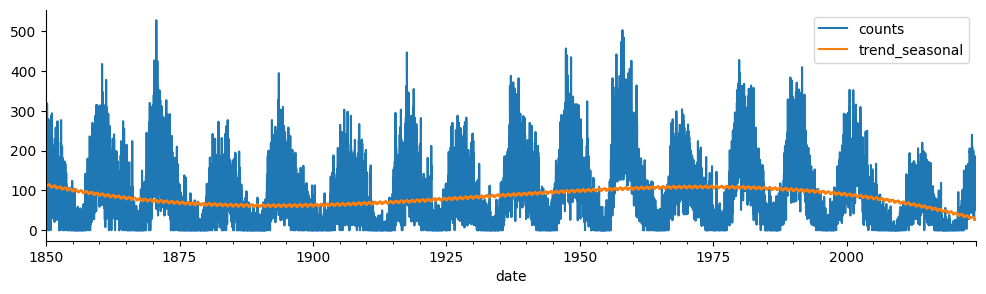

In [108]:
mpl.rc('figure',figsize=(12,3),dpi=100)
train[['counts','trend_seasonal']].plot(legend=True)
sns.despine()

In [109]:
train['remainder'] = train['counts'] - train['trend_seasonal']

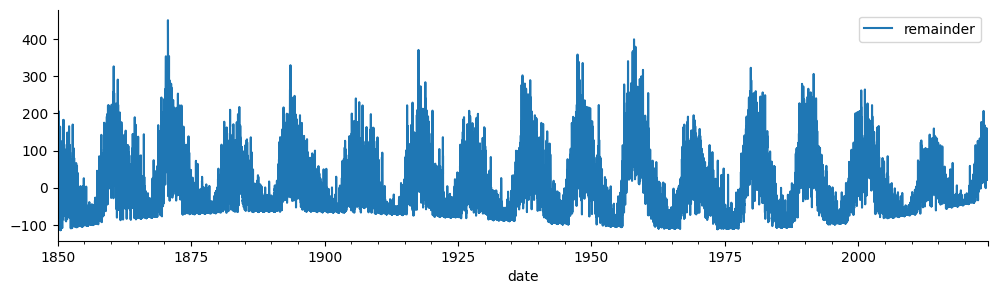

In [110]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train['remainder'].plot(legend=True)
sns.despine()

In [111]:
qcd_variance(train['remainder'])

quartile coefficient of dispersion: 0.339483


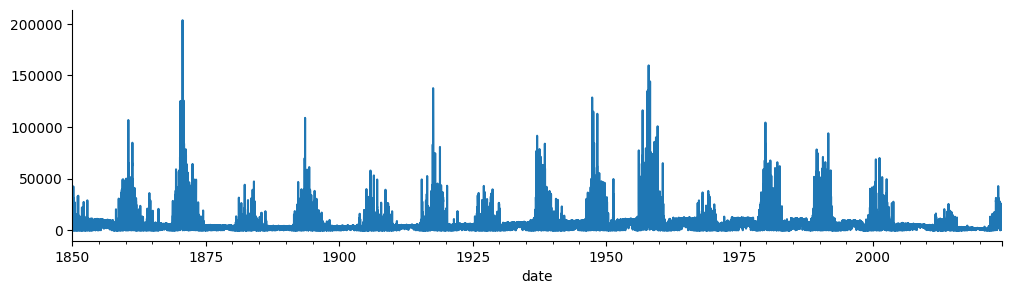

In [112]:
mpl.rc('figure',figsize=(12,3),dpi=100)
(train['remainder']**2).plot()
sns.despine()

In [113]:
train

,date,counts,timestep,trend,detrended,month,seasonality,trend_seasonal,remainder
date,,,,,,,,,
1850-01-01,1850-01-01,253,0,114.032692,138.967308,1,-3.871431,110.161261,142.838739
1850-01-02,1850-01-02,162,1,114.025075,47.974925,1,-3.871431,110.153644,51.846356
1850-01-03,1850-01-03,217,2,114.017459,102.982541,1,-3.871431,110.146028,106.853972
1850-01-04,1850-01-04,99,3,114.009844,-15.009844,1,-3.871431,110.138413,-11.138413
1850-01-05,1850-01-05,108,4,114.002229,-6.002229,1,-3.871431,110.130798,-2.130798
...,...,...,...,...,...,...,...,...,...
2024-03-27,2024-03-27,114,63638,28.760816,85.239184,3,-0.513842,28.246974,85.753026
2024-03-28,2024-03-28,98,63639,28.750937,69.249063,3,-0.513842,28.237095,69.762905
2024-03-29,2024-03-29,81,63640,28.741058,52.258942,3,-0.513842,28.227216,52.772784


In [114]:
def create_lagged_features(df, number_of_lags):
    """"""
    df = df[['remainder']]
    
    lags = list(range(1, number_of_lags+1))
    
    for lag in lags:
        column_name = 'lag_' + str(lag)
        df[column_name] = df['remainder'].shift(lag)
        
    return df

In [115]:
p = 10
df = create_lagged_features(train,p)
df
df_remainder = df.copy()
df_remainder

,remainder,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
date,,,,,,,,,,,
1850-01-01,142.838739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1850-01-02,51.846356,142.838739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1850-01-03,106.853972,51.846356,142.838739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1850-01-04,-11.138413,106.853972,51.846356,142.838739,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1850-01-05,-2.130798,-11.138413,106.853972,51.846356,142.838739,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2024-03-27,85.753026,112.743148,138.733271,137.723395,128.713519,135.703644,133.693770,95.683896,105.674023,90.664151,45.654280
2024-03-28,69.762905,85.753026,112.743148,138.733271,137.723395,128.713519,135.703644,133.693770,95.683896,105.674023,90.664151
2024-03-29,52.772784,69.762905,85.753026,112.743148,138.733271,137.723395,128.713519,135.703644,133.693770,95.683896,105.674023


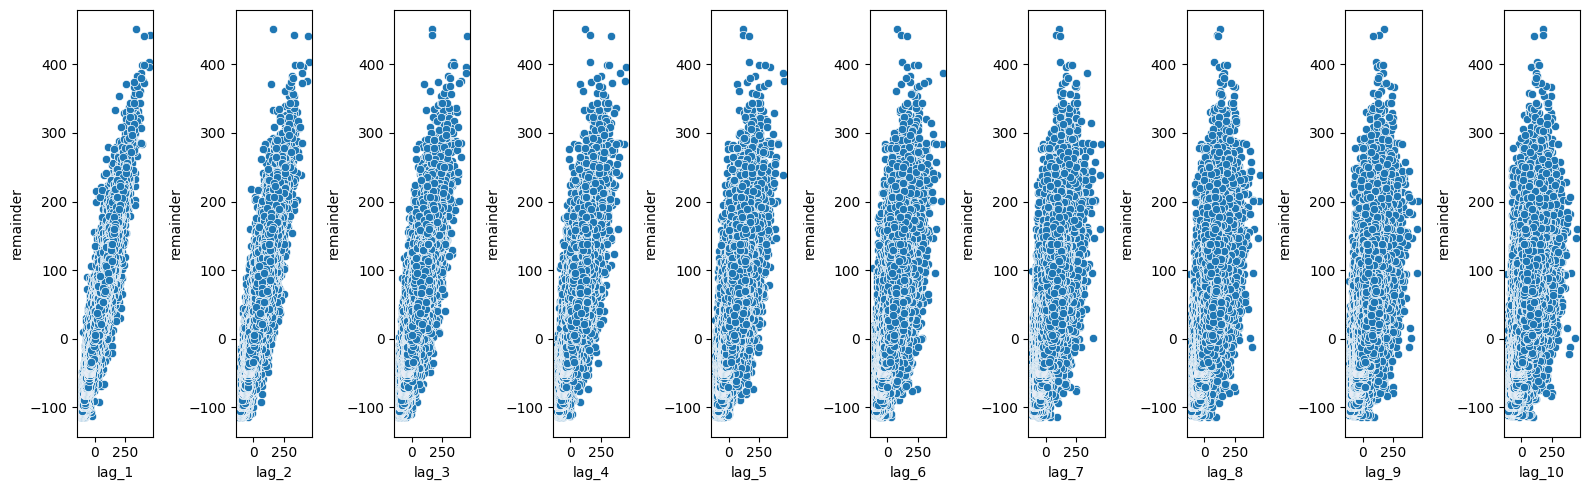

In [116]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

lag_columns = df.columns[-p:]
fig, axes = plt.subplots(1,p, figsize=(16,5),dpi=100)
gs = gridspec.GridSpec(1,p)

for i in range(p):
    sns.scatterplot(
        x=df[lag_columns[i]],
        y=df['remainder'],
        ax=axes[i]
    )
    
plt.tight_layout()

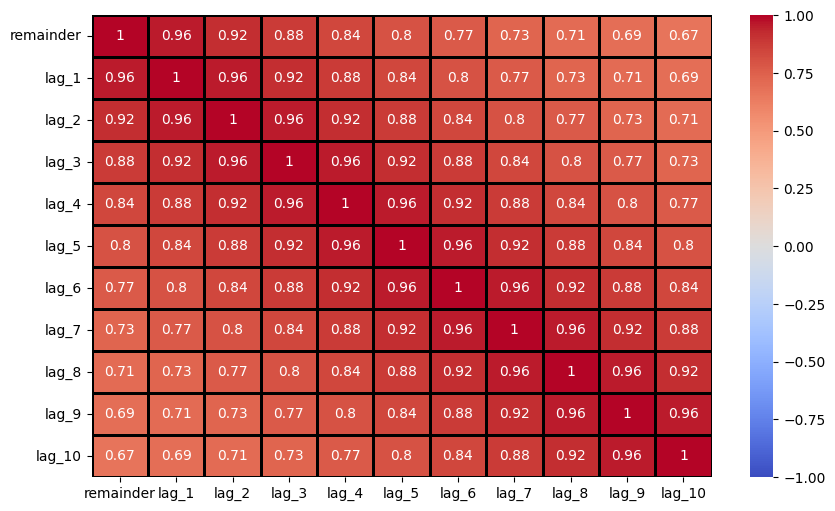

In [117]:
plt.rcParams['figure.figsize'] = (10,6)
sns.heatmap(round(df.corr(),2), 
            cmap = "coolwarm",
            linecolor='black', 
            linewidth=1, 
            annot=True,
            vmin=-1, 
            vmax=1
           );

In [118]:
df.dropna(inplace=True)
df.head()

,remainder,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
date,,,,,,,,,,,
1850-01-11,51.914876,13.907265,-15.100346,-34.107958,31.884429,92.876816,-2.130798,-11.138413,106.853972,51.846356,142.838739
1850-01-12,77.922486,51.914876,13.907265,-15.100346,-34.107958,31.884429,92.876816,-2.130798,-11.138413,106.853972,51.846356
1850-01-13,35.930096,77.922486,51.914876,13.907265,-15.100346,-34.107958,31.884429,92.876816,-2.130798,-11.138413,106.853972
1850-01-14,28.937704,35.930096,77.922486,51.914876,13.907265,-15.100346,-34.107958,31.884429,92.876816,-2.130798,-11.138413
1850-01-15,-45.054688,28.937704,35.930096,77.922486,51.914876,13.907265,-15.100346,-34.107958,31.884429,92.876816,-2.130798


In [119]:
# feature and target for autoregression model

X_remainder = df.drop('remainder',axis=1)
y_remainder = df['remainder']

In [120]:
ar_model = LinearRegression()
ar_model.fit(X_remainder,y_remainder)

LinearRegression()

In [121]:
df['ar_predictions'] = ar_model.predict(X_remainder)

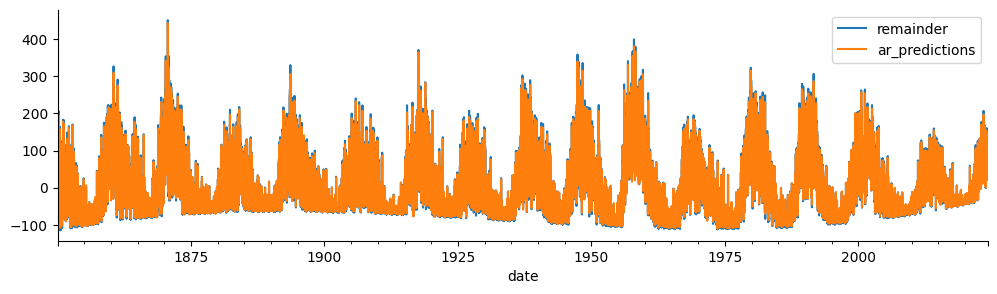

In [122]:
mpl.rc('figure',figsize=(12,3),dpi=100)

df[['remainder','ar_predictions']].plot(legend=True)
sns.despine()

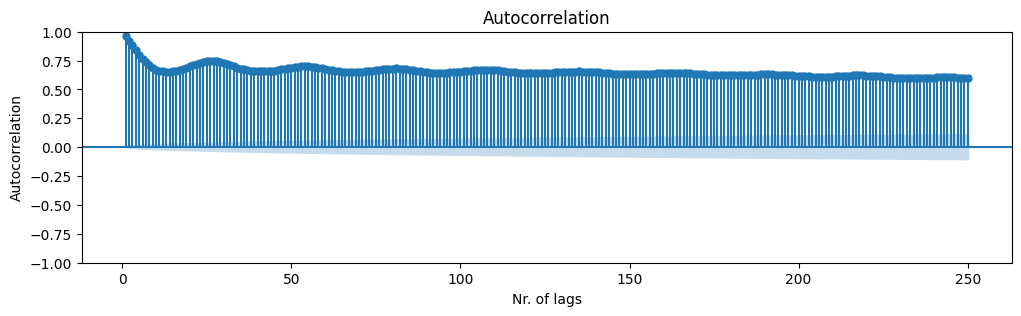

In [123]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rcParams["figure.dpi"] = 100
plot_acf(df['remainder'],zero=False,lags=250)
plt.xlabel('Nr. of lags')
plt.ylabel('Autocorrelation');

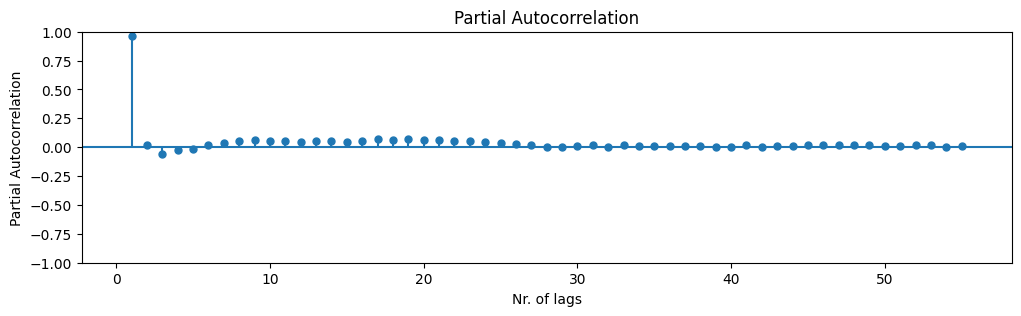

In [124]:
plot_pacf(df_remainder['remainder'],zero=False,lags=55)
plt.xlabel('Nr. of lags')
plt.ylabel('Partial Autocorrelation');

In [125]:
df['residuals_ar'] = df['remainder'] - df['ar_predictions']

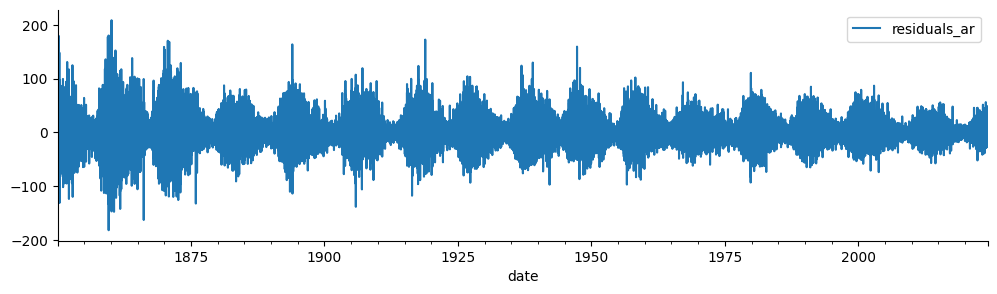

In [126]:
mpl.rc('figure',figsize=(12,3),dpi=100)

df['residuals_ar'].plot(legend=True)
sns.despine()

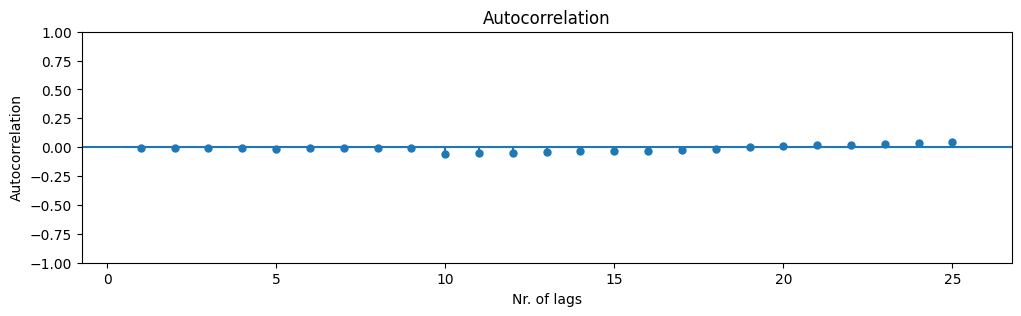

In [127]:
plot_acf(df['residuals_ar'],zero=False,lags=25)
plt.xlabel('Nr. of lags')
plt.ylabel('Autocorrelation');

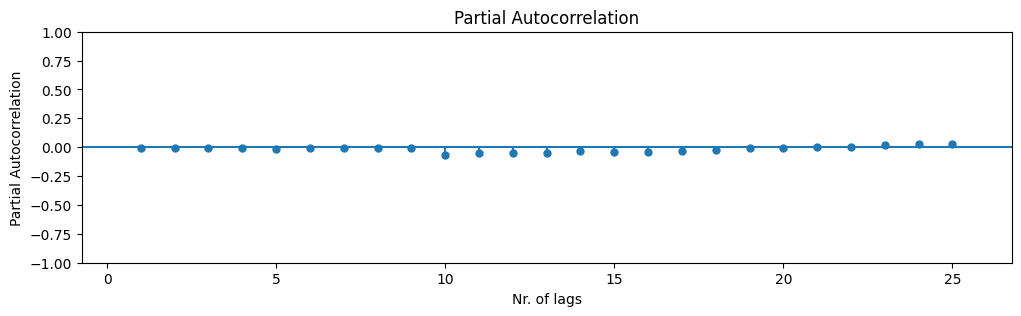

In [128]:
plot_pacf(df['residuals_ar'],zero=False,lags=25)
plt.xlabel('Nr. of lags')
plt.ylabel('Partial Autocorrelation');

In [129]:
# df_remainder = df
df_remainder

,remainder,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
date,,,,,,,,,,,
1850-01-01,142.838739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1850-01-02,51.846356,142.838739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1850-01-03,106.853972,51.846356,142.838739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1850-01-04,-11.138413,106.853972,51.846356,142.838739,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1850-01-05,-2.130798,-11.138413,106.853972,51.846356,142.838739,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2024-03-27,85.753026,112.743148,138.733271,137.723395,128.713519,135.703644,133.693770,95.683896,105.674023,90.664151,45.654280
2024-03-28,69.762905,85.753026,112.743148,138.733271,137.723395,128.713519,135.703644,133.693770,95.683896,105.674023,90.664151
2024-03-29,52.772784,69.762905,85.753026,112.743148,138.733271,137.723395,128.713519,135.703644,133.693770,95.683896,105.674023


In [130]:
train

,date,counts,timestep,trend,detrended,month,seasonality,trend_seasonal,remainder
date,,,,,,,,,
1850-01-01,1850-01-01,253,0,114.032692,138.967308,1,-3.871431,110.161261,142.838739
1850-01-02,1850-01-02,162,1,114.025075,47.974925,1,-3.871431,110.153644,51.846356
1850-01-03,1850-01-03,217,2,114.017459,102.982541,1,-3.871431,110.146028,106.853972
1850-01-04,1850-01-04,99,3,114.009844,-15.009844,1,-3.871431,110.138413,-11.138413
1850-01-05,1850-01-05,108,4,114.002229,-6.002229,1,-3.871431,110.130798,-2.130798
...,...,...,...,...,...,...,...,...,...
2024-03-27,2024-03-27,114,63638,28.760816,85.239184,3,-0.513842,28.246974,85.753026
2024-03-28,2024-03-28,98,63639,28.750937,69.249063,3,-0.513842,28.237095,69.762905
2024-03-29,2024-03-29,81,63640,28.741058,52.258942,3,-0.513842,28.227216,52.772784


In [131]:
df

,remainder,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,ar_predictions,residuals_ar
date,,,,,,,,,,,,,
1850-01-11,51.914876,13.907265,-15.100346,-34.107958,31.884429,92.876816,-2.130798,-11.138413,106.853972,51.846356,142.838739,18.367477,33.547399
1850-01-12,77.922486,51.914876,13.907265,-15.100346,-34.107958,31.884429,92.876816,-2.130798,-11.138413,106.853972,51.846356,50.802484,27.120002
1850-01-13,35.930096,77.922486,51.914876,13.907265,-15.100346,-34.107958,31.884429,92.876816,-2.130798,-11.138413,106.853972,81.257419,-45.327323
1850-01-14,28.937704,35.930096,77.922486,51.914876,13.907265,-15.100346,-34.107958,31.884429,92.876816,-2.130798,-11.138413,37.480336,-8.542632
1850-01-15,-45.054688,28.937704,35.930096,77.922486,51.914876,13.907265,-15.100346,-34.107958,31.884429,92.876816,-2.130798,27.726160,-72.780848
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-27,85.753026,112.743148,138.733271,137.723395,128.713519,135.703644,133.693770,95.683896,105.674023,90.664151,45.654280,105.239972,-19.486945
2024-03-28,69.762905,85.753026,112.743148,138.733271,137.723395,128.713519,135.703644,133.693770,95.683896,105.674023,90.664151,80.251711,-10.488806
2024-03-29,52.772784,69.762905,85.753026,112.743148,138.733271,137.723395,128.713519,135.703644,133.693770,95.683896,105.674023,64.612796,-11.840011


In [132]:
df.drop('remainder',axis=1, inplace=True)
# train_target

In [133]:


train_target = train.join(df, how='left')
train_target.head(30)

,date,counts,timestep,trend,detrended,month,seasonality,trend_seasonal,remainder,lag_1,...,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,ar_predictions,residuals_ar
date,,,,,,,,,,,,,,,,,,,,,
1850-01-01,1850-01-01,253,0,114.032692,138.967308,1,-3.871431,110.161261,142.838739,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1850-01-02,1850-01-02,162,1,114.025075,47.974925,1,-3.871431,110.153644,51.846356,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1850-01-03,1850-01-03,217,2,114.017459,102.982541,1,-3.871431,110.146028,106.853972,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1850-01-04,1850-01-04,99,3,114.009844,-15.009844,1,-3.871431,110.138413,-11.138413,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1850-01-05,1850-01-05,108,4,114.002229,-6.002229,1,-3.871431,110.130798,-2.130798,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1850-01-06,1850-01-06,203,5,113.994615,89.005385,1,-3.871431,110.123184,92.876816,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1850-01-07,1850-01-07,142,6,113.987001,28.012999,1,-3.871431,110.115571,31.884429,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1850-01-08,1850-01-08,76,7,113.979389,-37.979389,1,-3.871431,110.107958,-34.107958,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1850-01-09,1850-01-09,95,8,113.971777,-18.971777,1,-3.871431,110.100346,-15.100346,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [134]:
train_target['total_predictions'] = train_target['trend_seasonal'] + train_target['ar_predictions']
train_target.dropna()


,date,counts,timestep,trend,detrended,month,seasonality,trend_seasonal,remainder,lag_1,...,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,ar_predictions,residuals_ar,total_predictions
date,,,,,,,,,,,,,,,,,,,,,
1850-01-11,1850-01-11,162,10,113.956555,48.043445,1,-3.871431,110.085124,51.914876,13.907265,...,31.884429,92.876816,-2.130798,-11.138413,106.853972,51.846356,142.838739,18.367477,33.547399,128.452601
1850-01-12,1850-01-12,188,11,113.948945,74.051055,1,-3.871431,110.077514,77.922486,51.914876,...,-34.107958,31.884429,92.876816,-2.130798,-11.138413,106.853972,51.846356,50.802484,27.120002,160.879998
1850-01-13,1850-01-13,146,12,113.941335,32.058665,1,-3.871431,110.069904,35.930096,77.922486,...,-15.100346,-34.107958,31.884429,92.876816,-2.130798,-11.138413,106.853972,81.257419,-45.327323,191.327323
1850-01-14,1850-01-14,139,13,113.933726,25.066274,1,-3.871431,110.062296,28.937704,35.930096,...,13.907265,-15.100346,-34.107958,31.884429,92.876816,-2.130798,-11.138413,37.480336,-8.542632,147.542632
1850-01-15,1850-01-15,65,14,113.926118,-48.926118,1,-3.871431,110.054688,-45.054688,28.937704,...,51.914876,13.907265,-15.100346,-34.107958,31.884429,92.876816,-2.130798,27.726160,-72.780848,137.780848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-27,2024-03-27,114,63638,28.760816,85.239184,3,-0.513842,28.246974,85.753026,112.743148,...,128.713519,135.703644,133.693770,95.683896,105.674023,90.664151,45.654280,105.239972,-19.486945,133.486945
2024-03-28,2024-03-28,98,63639,28.750937,69.249063,3,-0.513842,28.237095,69.762905,85.753026,...,137.723395,128.713519,135.703644,133.693770,95.683896,105.674023,90.664151,80.251711,-10.488806,108.488806
2024-03-29,2024-03-29,81,63640,28.741058,52.258942,3,-0.513842,28.227216,52.772784,69.762905,...,138.733271,137.723395,128.713519,135.703644,133.693770,95.683896,105.674023,64.612796,-11.840011,92.840011


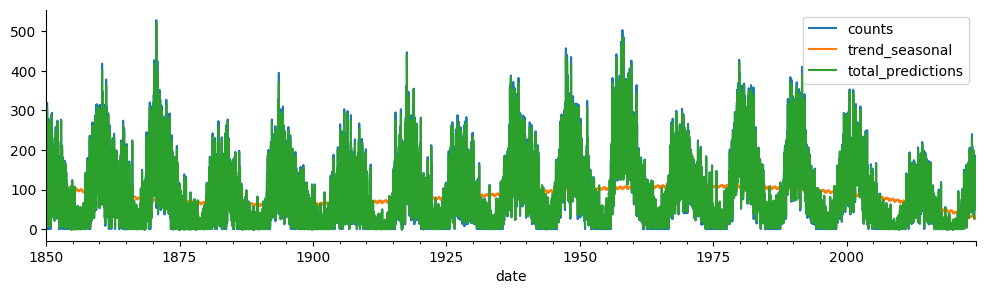

In [135]:
mpl.rc('figure',figsize=(12,3),dpi=100)
train_target[['counts','trend_seasonal','total_predictions']].plot(legend=True)
sns.despine()

In [136]:
X_trend.shape

(63643, 1)

In [137]:
r2_ts = round(trend_model.score(X_trend[10:],y_trend[10:]),6)
print(f"r2_score: {r2_ts}")

r2_score: 0.059707


In [138]:
y_trend

date
1850-01-01    253
1850-01-02    162
1850-01-03    217
1850-01-04     99
1850-01-05    108
             ... 
2024-03-27    114
2024-03-28     98
2024-03-29     81
2024-03-30     50
2024-03-31     66
Name: counts, Length: 63643, dtype: int64

In [139]:
from sklearn.metrics import r2_score

r2_tot = round(r2_score(y_trend[p:],train_target['total_predictions'][p:]),6)
print(f"r2_score: {r2_tot}")

r2_score: 0.927114


Forecasts (TEST)

In [140]:
test.head()

,date,counts
63643,2024-04-01,32
63644,2024-04-02,39
63645,2024-04-03,38
63646,2024-04-04,48
63647,2024-04-05,78


In [141]:
df.shape

(63633, 12)

In [142]:
test['timestep'] = list(
    range(train.shape[0], train.shape[0]+test.shape[0])
)

In [143]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 63643 to 63672
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      30 non-null     datetime64[ns]
 1   counts    30 non-null     int64         
 2   timestep  30 non-null     int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 852.0 bytes


In [144]:
test.set_index(test['date'], inplace = True)

In [145]:
X_test_trend = test[['timestep']]
y_test_trend = test['counts']

In [146]:
test['trend_model'] = trend_model.predict(X_test_trend)

In [147]:
test[['counts','trend_model']].head()

,counts,trend_model
date,,
2024-04-01,32,28.711415
2024-04-02,39,28.701533
2024-04-03,38,28.691650
2024-04-04,48,28.681766
2024-04-05,78,28.671881


In [148]:
def forecast_remainder(*lags):
    """
    spits out forecasted remainder for test data,
    given initial lagged variables
    """
    predicted_remainders = []
    lag_values = list(lags)
    
    for i in range(test.shape[0]):
        
        # row of lagged features
        X = [lag_values]
        
        # predict remainder
        remainder = ar_model.predict(X)[0]
        
        # append remainded
        predicted_remainders.append(remainder)
        
        # lag values for next step
        lag_values = [remainder] + lag_values[:-1]
        
    return predicted_remainders

In [149]:
train['remainder'].tail()

date
2024-03-27    85.753026
2024-03-28    69.762905
2024-03-29    52.772784
2024-03-30    21.782665
2024-03-31    37.792546
Name: remainder, dtype: float64

In [150]:
lags = [train.iloc[-1]['remainder'] 
,train.iloc[-2]['remainder'] 
, train.iloc[-3]['remainder'] 
, train.iloc[-4]['remainder'] 
, train.iloc[-5]['remainder'] 
, train.iloc[-6]['remainder'] 
, train.iloc[-7]['remainder'] 
, train.iloc[-8]['remainder'] 
, train.iloc[-9]['remainder'] 
, train.iloc[-10]['remainder'] ]
# lag1 = train.iloc[-1]['remainder'] 
# lag1
# lag10


In [151]:
lags

[37.79254550862993,
 21.782664616520602,
 52.77278445843535,
 69.76290503435189,
 85.75302634424907,
 112.74314838810415,
 138.7332711658953,
 137.72339467760116,
 128.71351892319922,
 135.7036439026674]

In [152]:
# train[-1:]
len(forecast_remainder(*lags))

30

In [153]:
test['total_pred'] = test['trend_model'] + forecast_remainder(*lags)
test['total_pred']

date
2024-04-01    64.511680
2024-04-02    65.917640
2024-04-03    68.713633
2024-04-04    72.885606
2024-04-05    75.891708
2024-04-06    77.553794
2024-04-07    78.041616
2024-04-08    77.267495
2024-04-09    74.587135
2024-04-10    72.698430
2024-04-11    70.456191
2024-04-12    68.285839
2024-04-13    66.319438
2024-04-14    64.730990
2024-04-15    63.481033
2024-04-16    62.513752
2024-04-17    61.749247
2024-04-18    61.097826
2024-04-19    60.434372
2024-04-20    59.783760
2024-04-21    59.097484
2024-04-22    58.365047
2024-04-23    57.586830
2024-04-24    56.780370
2024-04-25    55.963897
2024-04-26    55.155354
2024-04-27    54.368693
2024-04-28    53.612839
2024-04-29    52.889197
2024-04-30    52.199609
Name: total_pred, dtype: float64

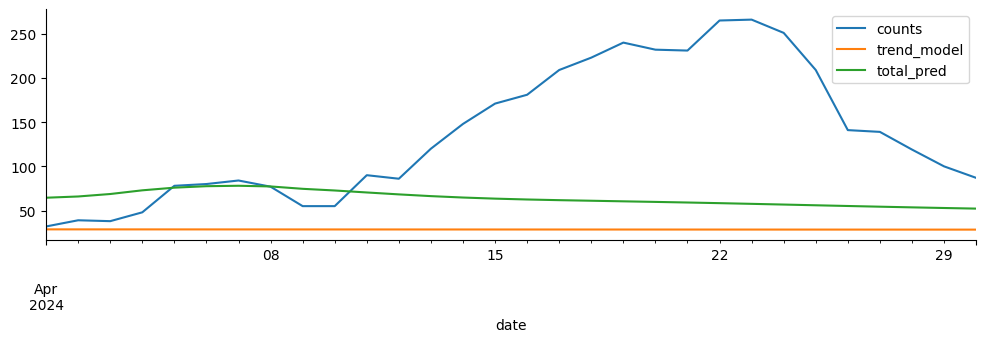

In [154]:
mpl.rc('figure',figsize=(12,3),dpi=100)
test[['counts','trend_model','total_pred']].plot(legend=True)
sns.despine()

In [155]:
r2_ts = round(trend_model.score(X_test_trend,y_test_trend),6)
print(f"r2_score: {r2_ts}")

r2_score: -2.05944


In [156]:
r2_tot = round(r2_score(y_test_trend,test['total_pred']),6)
print(f"r2_score: {r2_tot}")

r2_score: -1.0568


Checking  ARMA from ARIMA 

In [157]:
# !pip install pmdarima

In [158]:
import pmdarima as pm

In [161]:
# arima_model = pm.auto_arima(
#     df_remainder['remainder'], 
#     start_p=0,
#     max_p=5,
#     d=0,
#     seasonal = True,
#     m=3979,
#     stepwise=True,
#     trace = True,
#     n_jobs=-1
# )


RUNNING MORE THAN 78718...ETC

Performing stepwise search to minimize aic


Best model:  ARIMA(3,0,3)(0,0,0)[0]          
Total fit time: 458.079 seconds

To findout how many lags to use by function.

In [ ]:
from statsmodels.tsa.ar_model import ar_select_order
mod = ar_select_order(df_remainder['remainder'], maxlag=200)
mod.ar_lags

The above function says i need to use 53 lags - So confused here. 